<a id="top"></a>

<a id = '1.0'></a>
<h1 style = "font-family: garamond; font-size: 40px; font-style: normal;background-color: #2ab7ca; color : #fed766; border-radius: 5px 5px;padding:5px;text-align:center; font-weight: bold" >Quick Navigation</h1>

    
* [Dependencies and Configuration](#1)
* [Stage 3: Feature Engineering/Feature Selection](#2)
    * [Multicollinearity and Feature Selection](#31)
        * [Target Distribution](#31)
        * [Using Statsmodels Variance Inflation Factor](#31)
        * [Oh Dear, we have a Multicollinearity Problem](#31)
    * [Save the Data](#31)

# Dependencies and Configuration

In [1]:
import csv
import random
from functools import wraps
from time import time
from typing import Callable, Dict, List, Union

import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.evaluate import paired_ttest_5x2cv, bias_variance_decomp
from scipy import stats
from sklearn import (base, decomposition, dummy, ensemble, feature_selection,
                     linear_model, metrics, model_selection, neighbors,
                     pipeline, preprocessing, svm, tree)
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
class global_config:
    
    # File Path
    raw_data = "../data/raw/data.csv"
    processed_data_stage_1 = "../data/processed/data_stage_1.csv"
    processed_data_stage_2 = "../data/processed/data_stage_2.csv"
    processed_data_stage_3 = "../data/processed/data_stage_3.csv"
    
    spot_checking_boxplot = "../data/images/spot_checking_boxplot.png"
    oof_confusion_matrix = "../data/images/oof_confusion_matrix.png"
    final_train_confusion_matrix = "../data/images/final_train_confusion_matrix.png"
    precision_recall_threshold_plot = "../data/images/precision_recall_threshold_plot.png"
    roc_plot = "../data/images/roc_plot.png"
    
    # Data Information
    target = ["diagnosis"]
    unwanted_cols = ["id", "Unnamed: 32"]

    # Plotting
    colors = ["#fe4a49", "#2ab7ca", "#fed766", "#59981A"]
    cmap_reversed = plt.cm.get_cmap('mako_r')
    
    # Seed Number
    seed = 1992

    # Cross Validation
    num_folds = 5
    cv_schema = "StratifiedKFold"
    split_size = {"train_size": 0.9, "test_size": 0.1}


def set_seeds(seed: int = 1234) -> None:
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)

In [3]:
config = global_config

# set seeding for reproducibility
_ = set_seeds(seed = config.seed)

# read data
df = pd.read_csv(config.processed_data_stage_3)

# How EDA helped us?

<div class="alert alert-success" role="alert">
    <b>Insights derived from EDA:</b> 
    <li> We know we do not need to perform GroupKFold as the patients are uniquely defined by their IDs.
    <li> We noticed that the predictors are not on the same scale, and it may skew the model's weight on the coefficients, prompting us to perform a feature scaling in our pipeline.
    <li> We know there are quite a few cluster of highly correlated predictors, prompting us to take action in our pipeline.
</div>

# Cross-Validation Strategy

<div class="alert alert-block alert-danger">
<b>Generalization:</b>     
    <blockquote cite="https://www.huxley.net/bnw/four.html">
        <p>Ultimately, we are interested in the Generalization Error made by the model, that is, how well the model perform on <b>unseen data</b> that is not taken from our sample set $\mathcal{D}$. In general, we use <b>validation set</b> for <b>Model Selection</b> and the <b>test set</b> for <b>an estimate of generalization error</b> on new data.
            <br> <b>- Refactored from Elements of Statistical Learning, Chapter 7.2</b></p>
    </blockquote>
</div>

---

<div class="alert alert-success" role="alert">
    <b>Step 1: Train-Test-Split:</b> Since this dataset is relatively small, we will not use the <b>train-validation-test</b> split and only split into train and test in a ratio of 9:1, whereby the split is stratified on our target, using <code>stratify=y</code> parameter in <code>train_test_split()</code> to ensure that our target has equal representation in both train and test. We note that this is a relatively small dataset and in practice, we need a large sample size to get a reliable/stable split, it is also recommended to retrain the whole dataset (without the "unseen" test set) after we have done the model selection process (eg. finding best hyperparameters). 
</div>

---

<div class="alert alert-success" role="alert">
    <b>Step 2: Resampling Stategy:</b> Note that we will be performing <code>StratifiedKFold</code> as our resampling strategy. After our split in Step 1, we have a training set $X_{\text{train}}$, we will then perform our resampling strategy on this $X_{\text{train}}$. We will choose our choice of $K = 5$. The choice of $K$ is somewhat arbitrary, and is derived <a href="https://stats.stackexchange.com/questions/61783/bias-and-variance-in-leave-one-out-vs-k-fold-cross-validation">empirically</a>. 
</div>

---

To recap, we have the following:

- **Training Set ($X_{\text{train}}$)**: This will be further split into K validation sets during our cross-validation. This set is used to fit a particular hypothesis $h \in \mathcal{H}$.
- **Validation Set ($X_{\text{val}}$)**: This is split from our $X_{\text{train}}$ during cross-validation. This set is used for model selection (i.e. find best hyperparameters, attempt to produce a best hypothesis $g \in \mathcal{H}$).
- **Test Set ($X_{\text{test}}$)**: This is an unseen test set, and we will only use it after we finish tuning our model/hypothesis. Suppose we have a final best model $g$, we will use $g$ to predict on the test set to get an estimate of the generalization error (also called out-of-sample error).

---

<figure>
<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' width="500"/>
<figcaption align = "center"><b>Courtesy of scikit-learn on a typical Cross-Validation workflow.</b></figcaption>
</figure>

In [4]:
X = df.copy()
y = X.pop("diagnosis")

In [5]:
predictor_cols = X.columns.to_list()

In [6]:
# Split train - test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=config.split_size['train_size'], shuffle=True, stratify= y, random_state=config.seed)

We confirm that we have stratified properly. We do observe that the distribution of targets in both `y_train` and `y_test` are similar.

In [7]:
print(f"Y Train Distribution is : {y_train.value_counts(normalize=True).to_dict()}")
print(f"Y Test Distribution is : {y_test.value_counts(normalize=True).to_dict()}")

Y Train Distribution is : {0: 0.626953125, 1: 0.373046875}
Y Test Distribution is : {0: 0.631578947368421, 1: 0.3684210526315789}


In [8]:
def make_folds(
    df: pd.DataFrame,
    num_folds: int,
    cv_schema: str,
    seed: int,
    predictor_col: List,
    target_col: List,
) -> pd.DataFrame:
    """Split the given dataframe into training folds.

    Args:
        df (pd.DataFrame): [description]
        num_folds (int): [description]
        cv_schema (str): [description]
        seed (int): [description]

    Returns:
        pd.DataFrame: [description]
    """

    if cv_schema == "KFold":
        df_folds = df.copy()
        kf = model_selection.KFold(n_splits=num_folds, shuffle=True, random_state=seed)

        for fold, (train_idx, val_idx) in enumerate(
            kf.split(X=df_folds[predictor_col], y=df_folds[target_col])
        ):
            df_folds.loc[val_idx, "fold"] = int(fold + 1)

        df_folds["fold"] = df_folds["fold"].astype(int)

    elif cv_schema == "StratifiedKFold":
        df_folds = df.copy()
        skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

        for fold, (train_idx, val_idx) in enumerate(
            skf.split(X=df_folds[predictor_col], y=df_folds[target_col])
        ):
            df_folds.loc[val_idx, "fold"] = int(fold + 1)

        df_folds["fold"] = df_folds["fold"].astype(int)
        print(df_folds.groupby(["fold", "diagnosis"]).size())

    return df_folds

In [9]:
X_y_train = pd.concat([X_train, y_train], axis = 1).reset_index(drop=True)
df_folds = make_folds(X_y_train, num_folds=config.num_folds, cv_schema=config.cv_schema, seed=config.seed, predictor_col= predictor_cols, target_col = config.target)

fold  diagnosis
1     0            64
      1            39
2     0            65
      1            38
3     0            64
      1            38
4     0            64
      1            38
5     0            64
      1            38
dtype: int64


Looks good! All our five folds are stratified!

# Modelling

## Spot Checking Algorithms

<div class="alert alert-success" role="alert">
    <b>Terminology Alert!</b> This method is advocated by <a href="https://machinelearningmastery.com/">Jason Brownlee PhD</a> and this serves as the first stage of my modelling process. We will rapidly test (spot check) different classifier algorithms, from <code>DummyClassifier</code>, to <code>LinearModel</code> to more sophisticated ensemble trees like <code>RandomForest</code>. 
</div>

---

I also note to the readers that we need to think of a few things when choosing the "optimal" machine learning algorithm:

- [No Lunch Free Theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem) intuitively says that no single optimization algorithm can work best in all situations. Therefore, spot checking can help us form a basis of which algorithm might work better in this particular scenario.
- [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor) often appears in many Machine Learning textbook, and the narrative is that a simpler model more often times generalizes better than a complex model. This is not unfamiliar when we think of the bias-variance tradeoff, and that is why there is always a tradeoff that we must make.

### Make Basic Pipeline (Say No to Data Leakage!)

<div class="alert alert-block alert-danger">
<b>Say No to Data Leakage:</b> This has been emphasized throughout and we must be careful as we should never touch the test set when fitting the model.
    <li> This means that preprocessing steps such as <code>StandardScaling()</code> should only be fitted on the training data, and then apply the same transformation (mean and std) on the test data. In other words, do not apply scaling on the whole dataset before splitting. 
    <li> However, it is also equally important to take note <b>not to contaminate</b> our validation set, which is often overlooked, resulting in over optimistic results from model selection phase, but perform badly on unseen test set. As a result, when we use a 5 fold cross validation, we should be careful during fitting that the preprocessing steps are only applied on the training folds, and not on all 5 folds.
    <li> The same idea is also applied to our <code>ReduceVIF()</code> preprocessing step. We should also include this in our pipeline and not select the features outside the cross-validation loop.</li>
</div>   
    
Scikit Learn's `Pipeline` object will prevent us from data leakage, as the steps in a pipeline is already pre-defined. There is also a lot of flexibility in this object, as you can even write custom functions in your pipeline!

In [10]:
class ReduceVIF(base.BaseEstimator, base.TransformerMixin):
    """The base of the class structure is implemented in https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class;
    I heavily modified the class such that it can take in numpy arrays and correctly implemented the fit and transform method.
    """

    def __init__(self, thresh=10):
        self.thresh = thresh
        self.feature_names_ = None
        self.predictor_cols = [
            "radius_mean",
            "texture_mean",
            "perimeter_mean",
            "area_mean",
            "smoothness_mean",
            "compactness_mean",
            "concavity_mean",
            "concave points_mean",
            "symmetry_mean",
            "fractal_dimension_mean",
            "radius_se",
            "texture_se",
            "perimeter_se",
            "area_se",
            "smoothness_se",
            "compactness_se",
            "concavity_se",
            "concave points_se",
            "symmetry_se",
            "fractal_dimension_se",
            "radius_worst",
            "texture_worst",
            "perimeter_worst",
            "area_worst",
            "smoothness_worst",
            "compactness_worst",
            "concavity_worst",
            "concave points_worst",
            "symmetry_worst",
            "fractal_dimension_worst",
        ]

    def reset(self):
        """Resets the state of predictor columns after each fold."""

        self.predictor_cols = [
            "radius_mean",
            "texture_mean",
            "perimeter_mean",
            "area_mean",
            "smoothness_mean",
            "compactness_mean",
            "concavity_mean",
            "concave points_mean",
            "symmetry_mean",
            "fractal_dimension_mean",
            "radius_se",
            "texture_se",
            "perimeter_se",
            "area_se",
            "smoothness_se",
            "compactness_se",
            "concavity_se",
            "concave points_se",
            "symmetry_se",
            "fractal_dimension_se",
            "radius_worst",
            "texture_worst",
            "perimeter_worst",
            "area_worst",
            "smoothness_worst",
            "compactness_worst",
            "concavity_worst",
            "concave points_worst",
            "symmetry_worst",
            "fractal_dimension_worst",
        ]

    def fit(self, X, y=None):
        """Fits the Recursive VIF on the training folds and save the selected feature names in self.feature_names

        Args:
            X ([type]): [description]
            y ([type], optional): [description]. Defaults to None.

        Returns:
            [type]: [description]
        """

        # print("ReduceVIF fit")
        tmp, self.predictor_cols = ReduceVIF.calculate_vif(X, self.predictor_cols, self.thresh)
        self.feature_names_ = self.predictor_cols  # save as an attribute to call later
        col_index = [self.predictor_cols.index(col_name) for col_name in self.predictor_cols]
        self.col_index = col_index
        self.reset()
        return self

    def transform(self, X, y=None):
        """Transforms the Validation Set according to the selected feature names.

        Args:
            X ([type]): [description]
            y ([type], optional): [description]. Defaults to None.

        Returns:
            [type]: [description]
        """
        # print("ReduceVIF transform")
        return X[:, self.col_index]

    @staticmethod
    def calculate_vif(X: Union[np.ndarray, pd.DataFrame], columns: List[str], thresh: float = 10.0):
        """Implements a VIF function that recursively eliminates features.

        Args:
            X (Union[np.ndarray, pd.DataFrame]): [description]
            columns (List[str]): [description]
            thresh (float, optional): [description]. Defaults to 10.0.

        Returns:
            [type]: [description]
        """

        dropped = True
        count = 0
        while dropped and count <= 20:
            column_index = X.shape[1]
            predictor_cols = np.arange(X.shape[1])
            dropped = False
            vif = []
            for var in range(column_index):
                vif.append(variance_inflation_factor(X[:, predictor_cols], var))

            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                # print(f"Dropping {maxloc} with vif={max_vif}")
                # X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                X = np.delete(X, maxloc, axis=1)
                columns.pop(maxloc)
                dropped = True
                count += 1
        return X, columns


In [11]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
    """Make a Pipeline for Training.

    Args:
        model ([type]): [description]

    Returns:
        [type]: [description]
    """
    
    steps = list()
    # standardization
    steps.append(('standardize', preprocessing.StandardScaler()))
    # reduce VIF
    steps.append(("remove_multicollinearity", ReduceVIF(thresh=10)))
    # the model
    steps.append(('model', model))
    # create pipeline
    _pipeline = pipeline.Pipeline(steps=steps)
    return _pipeline

In [12]:
classifiers = [
    # baseline model
    dummy.DummyClassifier(random_state=config.seed, strategy='stratified'),
    # linear model
    linear_model.LogisticRegression(random_state=config.seed, solver='liblinear'),
    # nearest neighbours
    neighbors.KNeighborsClassifier(n_neighbors=8),
    # SVM
    svm.SVC(probability=True, random_state=config.seed),
    # tree
    tree.DecisionTreeClassifier(random_state=config.seed),
    # ensemble
    ensemble.RandomForestClassifier(random_state=config.seed),
]

In [13]:
classifiers = [make_pipeline(model) for model in classifiers]

<div class="alert alert-block alert-danger">
<b>Careful when using ROC function!</b>   
    
We also note that when passing arguments to scikit-learn's <code>roc_auc_score</code> function, we should be careful not to pass <code>y_score=model.predict(X)</code> inside as we have to understand that we are passing in <b>non-thresholded</b> probabilities into <code>y_score</code>. If you pass the predicted values (full of 0 and 1s), then you are thresholding on 0 and 1 only, which is incorrect by definition. 
</div>


### Define Metrics

<div class="alert alert-block alert-danger">
<b>Say No to Accuracy:</b> Consider an imbalanced set, where the training data set has 100 patients (data points), and the ground truth is 90 patients are of class = 0, which means that these patients do not have cancer, whereas the remaining 10 patients are in class 1, where they do have cancer. This is an example of class imbalance where the ratio of class 1 to class 0 is 1:9.
</div>   
    
Consider **a baseline (almost trivial) classifier**:

```python
def zeroR(patient_data):
        training...
    return benign
```
        

where we predict the patient's class as the most frequent class. Meaning, the most frequent class in this question is the class = 0, where patients do not have cancer, so we just assign this class to everyone in this set. By doing this, we will inevitably achieve a **in-sample** accuracy rate of $\frac{90}{100} = 90\%$. But unfortunately, this supposedly high accuracy value is completely useless, because this classifier did not label any of the cancer patients correctly.

The consequence can be serious, assuming the test set has the same distribution as our training set, where if we have a test set of 1000 patients, there are 900 negative and 100 positive. Our model just literally predict every one of them as benign, yielding a $90\%$ **out-of-sample** accuracy.

What did we conclude? Well, for one, our `accuracy` can be 90% high and looks good to the laymen, but it failed to predict the most important class of people - yes, misclassifying true cancer patients as healthy people is very bad! 

---

<div class="alert alert-block alert-info">
<b>Optimizing Recall over Precision!</b>   
    
This is often a choice to make in business, from the confusion matrix and the out of fold roc scores, we are indeed approaching quite high score even without hyperparameter tuning. In the context of cancer prediction, it is often more important to minimize the False Negatives (assuming malignant to be the positive class), more than anything else. This is because the <b>cost</b> of wrongly classifying a malignant patient as benign is way more than wrong classifying a benign patient as malignant. 
    However, one needs to be careful not to <b> optimize the recall score </b> by calling the <code>recall_score()</code> function. This is because the recall function is already thresholded and you won't be able to optimize it any further. We will use ROC score as the metric to measure our performance, we will also show how we can choose a particular threshold from the ROC curve later. We may also introduce Precision-Recall curve to compare with ROC curve.
</div>

In [14]:
def train_on_fold(
    df_folds: pd.DataFrame,
    models: List[Callable],
    num_folds: int,
    predictor_col: List,
    target_col: List,
) -> Dict[str, List]:
    """Take in a dataframe with fold number as column, and a models which holds a list of callable models, we will loop through and return a dictionary of cv results.

    Args:
        df_folds (pd.DataFrame): [description]
        model (Callable): [description]
        num_folds (int): [description]
        predictor_col (List): [description]
        target_col (List): [description]


    Returns:
        Dict[str, List]: [description]
    """
  
    y_true = df_folds[target_col].values.flatten()

    # test_pred_arr: np.ndarray = np.zeros(len(X_test))

    model_dict = {}

    for model in models:
        result_dict: Dict = {
            "identifier": [],
            "y_true": [],
            "y_pred": [],
            "y_prob": [],
            "brier_loss": [],
            "roc": [],
            "precision": [],
            "recall": [],
            "f1": [],
            "confusion_matrix":[]
        }

        if isinstance(model, pipeline.Pipeline):
            model_name = model["model"].__class__.__name__
        else:
            model_name = model.__class__.__name__

        # out-of-fold validation predictions
        oof_pred_arr: np.ndarray = np.zeros(len(df_folds))
      
        for fold in range(1, num_folds + 1):

            train_df = df_folds[df_folds["fold"] != fold].reset_index(drop=True)
            val_df = df_folds[df_folds["fold"] == fold].reset_index(drop=True)
            val_idx = df_folds[df_folds["fold"] == fold].index.values
            X_train, y_train = train_df[predictor_col].values, train_df[target_col].values.ravel()
            X_val, y_val = val_df[predictor_col].values, val_df[target_col].values.ravel()
    
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            y_val_prob = model.predict_proba(X_val)[:, 1]
            result_dict["y_true"].append(y_val)
            result_dict["y_pred"].append(y_val_pred)
            result_dict["y_prob"].append(y_val_prob)
            
            val_score = metrics.roc_auc_score(y_true=y_val, y_score=y_val_prob)
            precision, recall, fbeta_score, _ = metrics.precision_recall_fscore_support(y_true=y_val, y_pred = y_val_pred, labels=[0, 1], average=None)
            
            oof_pred_arr[val_idx] = y_val_pred.ravel()

            result_dict["identifier"].append(f"fold {fold}")
            result_dict["roc"].append(val_score)
            result_dict["precision"].append(precision)
            result_dict["recall"].append(recall)
            result_dict["f1"].append(fbeta_score)
            result_dict["brier_loss"].append(metrics.brier_score_loss(y_true=y_val, y_prob=y_val_prob))
            result_dict["confusion_matrix"].append(metrics.confusion_matrix(y_val, y_val_pred))
           
        if model_name not in model_dict:
            model_dict[model_name] = result_dict

    return model_dict

In [15]:
model_dict = train_on_fold(df_folds, models = classifiers, num_folds=5, predictor_col=predictor_cols, target_col = config.target)

In [16]:
def add_summary_col(inner_dict):
    for k, v in inner_dict.items():
        if k == "identifier":
            inner_dict[k].extend(["mean_cv", "oof_cv"])
        elif k in ["y_true", "y_pred", "y_prob"]:
            inner_dict[k].append(np.concatenate(v))
            inner_dict[k].append(inner_dict[k][-1])
        elif k in ["roc", "brier_loss"]:
            inner_dict[k].extend([sum(v) / len(v), None])
        elif k in ["precision", "recall", "f1"]:
            i0s = [elm[0] for elm in v]
            i1s = [elm[1] for elm in v]
            inner_dict[k].extend([[sum(i0s) / len(i0s), sum(i1s) / len(i1s)], None])
        else:
            inner_dict[k].extend([None, None])
    inner_dict["confusion_matrix"][-2] = metrics.confusion_matrix(
        inner_dict["y_true"][-1], inner_dict["y_pred"][-1]
    )
    inner_dict["confusion_matrix"][-1] = inner_dict["confusion_matrix"][-2].copy()
    inner_dict["roc"][-1] = metrics.roc_auc_score(
        y_true=inner_dict["y_true"][-1], y_score=inner_dict["y_prob"][-1]
    )


for v in model_dict.values():
    add_summary_col(v)

In [17]:
results_df = pd.concat({k: pd.DataFrame(v).T for k, v in model_dict.items()}, axis=0)
results_df.columns = ['fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5', 'mean_cv', 'oof_cv']
results_df

fold 1  \
DummyClassifier        identifier                                                   fold 1   
                       y_true            [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...   
                       y_pred            [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...   
                       brier_loss                                                 0.475728   
                       roc                                                        0.502003   
                       precision                 [0.6229508196721312, 0.38095238095238093]   
                       recall                               [0.59375, 0.41025641025641024]   
                       f1                                     [0.608, 0.39506172839506165]   
                       confusion_matrix                               [[38, 26], [23, 16]]   
LogisticRegression     identifier                                                   fold 1   
                       y_true            [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...   
                       y_pred            [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [0.9989490645663124, 0.02190026109632574, 0.97...   
                       brier_loss                                                 0.033036   
                       roc                                                        0.992788   
                       precision                  [0.9538461538461539, 0.9473684210526315]   
                       recall                                [0.96875, 0.9230769230769231]   
                       f1                          [0.9612403100775193, 0.935064935064935]   
                       confusion_matrix                                 [[62, 2], [3, 36]]   
KNeighborsClassifier   identifier                                                   fold 1   
                       y_true            [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...   
                       y_pred            [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [1.0, 0.0, 1.0, 0.0, 0.0, 0.125, 1.0, 0.0, 0.1...   
                       brier_loss                                                 0.062803   
                       roc                                                        0.968149   
                       precision                  [0.9230769230769231, 0.8947368421052632]   
                       recall                                 [0.9375, 0.8717948717948718]   
                       f1                         [0.9302325581395349, 0.8831168831168831]   
                       confusion_matrix                                 [[60, 4], [5, 34]]   
SVC                    identifier                                                   fold 1   
                       y_true            [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...   
                       y_pred            [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [0.9999996604648862, 0.027676793478997694, 0.9...   
                       brier_loss                                                 0.035543   
                       roc                                                        0.991987   
                       precision                            [0.953125, 0.9230769230769231]   
                       recall                               [0.953125, 0.9230769230769231]   
                       f1                                   [0.953125, 0.9230769230769231]   
                       confusion_matrix                                 [[61, 3], [3, 36]]   
DecisionTreeClassifier identifier                                                   fold 1   
                       y_true            [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...   
                       y_pred            [

### Comparison of Cross-Validated Models

The point of the following comparison is to check how different models are performing across folds. More specifically, if we have 5 folds, we will have a metric score for each fold, subsequently, we can find the standard error of model's performance. We need to be aware of models that have high variance across folds in terms of the metrics performance. This can indicate that the model is highly unstable, and may be a sign of overfitting.

,model,fold,roc
24,DecisionTreeClassifier,fold 1,0.883413
25,DecisionTreeClassifier,fold 2,0.872672
26,DecisionTreeClassifier,fold 3,0.881990
27,DecisionTreeClassifier,fold 4,0.923931
28,DecisionTreeClassifier,fold 5,0.897615
29,DecisionTreeClassifier,SE,0.008940
30,RandomForestClassifier,fold 1,0.987780
31,RandomForestClassifier,fold 2,0.991093
32,RandomForestClassifier,fold 3,0.986020
33,RandomForestClassifier,fold 4,0.977796


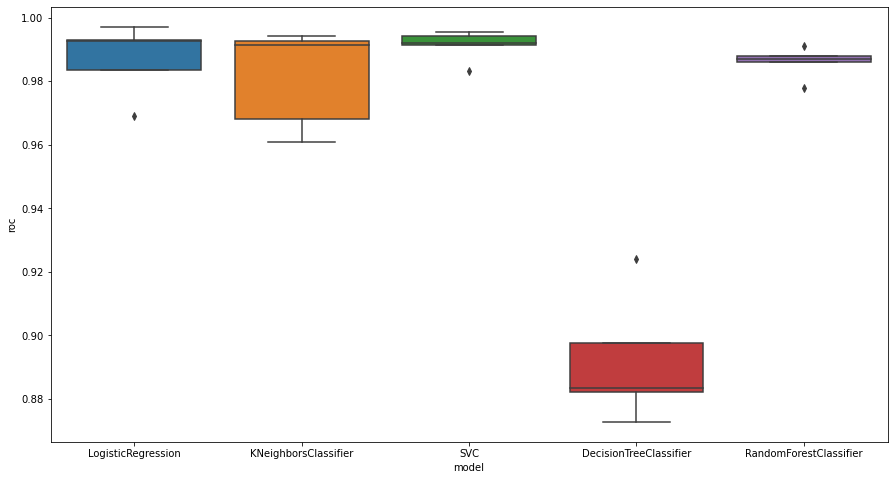

In [18]:
def summarize_metrics(metric_name):
    ls = []
    for model_name, inner_dict in model_dict.items():
        folds = inner_dict["identifier"][:-2]
        all_obs = []
        for idx, obs in enumerate(inner_dict[metric_name][:-2]):
            ls.append((model_name, folds[idx], obs))
            all_obs.append(obs)
        ls.append((model_name, "SE", np.std(all_obs, ddof=1) / len(all_obs) ** 0.5))
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    summary_df = pd.DataFrame(ls, columns=["model", "fold", metric_name])
    # summary_df.to_csv
    _ = sns.boxplot(x="model", y=metric_name, data=summary_df[(summary_df['model'] != 'DummyClassifier') & (summary_df['fold'] != 'SE')], ax=ax)
    
    fig.savefig(config.spot_checking_boxplot, format='png', dpi=300)
    
    return summary_df


summary_df = summarize_metrics("roc")
display(summary_df.tail(12))

### Out-of-Fold Confusion Matrix

We do have information on the performance of each folds, we now look at the performance of all 5 folds together. Typicall there are two ways to do it, one is to simply take the average of the score of five folds, the other is to take a look at out of folds predictions.

---

From the confusion matrix of the out of fold performance, Logistic Regression does seem to be a model we can explore on, although slightly lower in terms of overall AUROC score than SVC, it seems to have the quite low False Negatives amongst all. With further hyperparameter tuning and threshold optimization, we can make it better.

In [19]:
model_names = [model for model in model_dict.keys()]

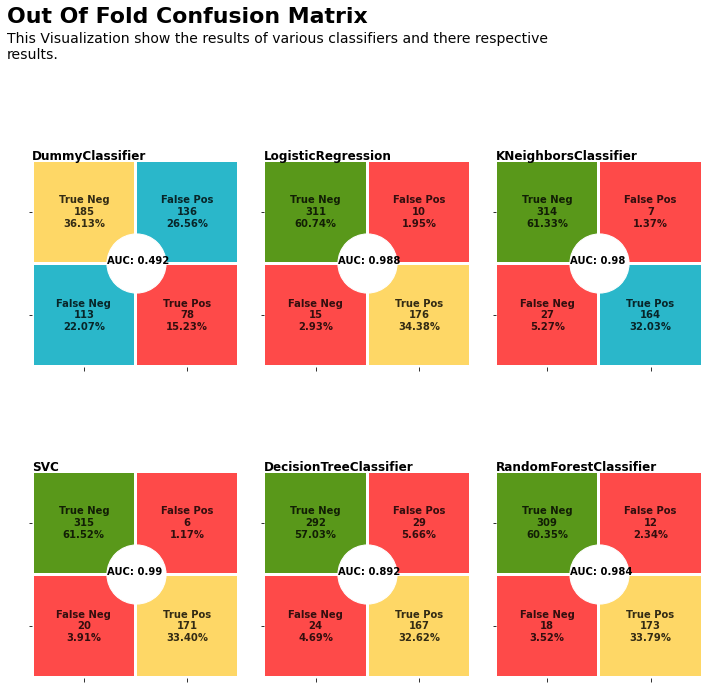

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for axes, algo in zip(ax.ravel(), model_names):

    cf_mat = results_df.oof_cv[algo].confusion_matrix

    #### scores
    auc = results_df.oof_cv[algo].roc

    #### annotations
    labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
    counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten() / np.sum(cf_mat)]

    #### final annotations
    label = (
        np.array([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)])
    ).reshape(2, 2)

    # heatmap
    sns.heatmap(
        data=cf_mat,
        vmin=0,
        vmax=330,
        cmap=["#fe4a49", "#2ab7ca", "#fed766", "#59981A"],
        linewidth=2,
        linecolor="white",
        square=True,
        ax=axes,
        annot=label,
        fmt="",
        cbar=False,
        annot_kws={"size": 10, "color": "black", "weight": "bold", "alpha": 0.8},
        alpha=1,
    )

    axes.text(0, -0, "{}".format(algo), {"size": 12, "color": "black", "weight": "bold"})

    axes.scatter(1, 1, s=3500, c="white")
    axes.text(
        0.72,
        1.0,
        "AUC: {}".format(round(auc, 3)),
        {"size": 10, "color": "black", "weight": "bold"},
    )

    ## ticks and labels
    axes.set_xticklabels("")
    axes.set_yticklabels("")


## titles and text
fig.text(0, 1.05, "Out Of Fold Confusion Matrix", {"size": 22, "weight": "bold"}, alpha=1)
fig.text(
    0,
    1,
    """This Visualization show the results of various classifiers and there respective
results.""",
    {"size": 14, "weight": "normal"},
    alpha=0.98,
)


fig.tight_layout(pad=2.5, w_pad=2.5, h_pad=2.5)
fig.savefig(config.oof_confusion_matrix, format='png', dpi=300)

### Hypothesis Testing Across Models

I am slightly shocked at the performance of plain LogisticRegression, I decide to use an idea from [Hypothesis Testing Across Models](http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_kfold_cv/) to check if the difference is really by chance or not. Note that I will be modifying his code as his code does not split using StratifiedKFold.

---

The basic idea is to test if two model's difference in scores (in this case roc), is statistically significant or not. However, we note that this method may violate an assumption of Student's t test.

---

- Null Hypothesis $H_0$: The difference in the performance score of two classifiers is Statistically Significant.
- Alternate Hypothesis $H_1$: The difference in the performance score of two classifiers is **not** Statistically Significant.

In [21]:
def paired_ttest_skfold_cv(
    estimator1, estimator2, X, y, cv=10, scoring=None, shuffle=False, random_seed=None
):
    """Modified from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/ttest.py to accomodate StratifiedKFold"""

    if not shuffle:
        skf = model_selection.StratifiedKFold(n_splits=cv, shuffle=shuffle)
    else:
        skf = model_selection.StratifiedKFold(
            n_splits=cv, random_state=random_seed, shuffle=shuffle
        )

    if scoring is None:
        if estimator1._estimator_type == "classifier":
            scoring = "accuracy"
        elif estimator1._estimator_type == "regressor":
            scoring = "r2"
        else:
            raise AttributeError("Estimator must " "be a Classifier or Regressor.")
    if isinstance(scoring, str):
        scorer = metrics.get_scorer(scoring)
    else:
        scorer = scoring

    score_diff = []

    for train_index, test_index in skf.split(X=X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        estimator1.fit(X_train, y_train)
        estimator2.fit(X_train, y_train)

        est1_score = scorer(estimator1, X_test, y_test)
        est2_score = scorer(estimator2, X_test, y_test)
        score_diff.append(est1_score - est2_score)

    avg_diff = np.mean(score_diff)

    numerator = avg_diff * np.sqrt(cv)
    denominator = np.sqrt(sum([(diff - avg_diff) ** 2 for diff in score_diff]) / (cv - 1))
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), cv - 1) * 2.0
    return float(t_stat), float(pvalue)


In [22]:
# check if difference between algorithms is real
X_tmp = X_y_train[predictor_cols].values
y_tmp = X_y_train['diagnosis'].values

t, p = paired_ttest_skfold_cv(estimator1=classifiers[1], estimator2=classifiers[-1],shuffle=True,cv=5, X=X_tmp, y=y_tmp, scoring='roc_auc', random_seed=config.seed)

In [23]:
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.831, t-Statistic: 0.228


Since P value is quite high, and more the basic threshold of 0.05 or 0.1, we fail to reject the null hypothesis, and say that there is no significant difference between these two models.

## Model Selection: Hyperparameter Tuning with GridSearchCV

<div class="alert alert-success" role="alert">
    <b>Hyperparameter Tuning:</b>
    <li> We have done a quick spot checking on algorithms and realized that <code>LogisticRegression</code> is doing well for this task. For this purpose, I will just perform hyperparameter tuning on this single algorithm. However, in practice and if resources are allowed, I will also tune other models such as <code>RandomForest()</code>, or gradient boosting algorithms such as <code>XGBoost</code>, as I believe they will perform no worse than our Logistic Regression model given the right hyperparameters.
</div>

---

<div class="alert alert-info" role="alert">
    <b>Grid Search:</b>
    <li> We will use an old-fashioned way to search for hyperparameters, which is brute force method. The time complexity of Grid Search is high and if you have many hyperparameters to tune, I recommend trying out <b>Random Grid Search</b> or libraries like <b>Optuna</b> that uses Bayesian Optimization.
</div>

In [24]:
def make_finetuning_pipeline(model):
    """Make a Pipeline for Training.

    Args:
        model ([type]): [description]

    Returns:
        [type]: [description]
    """
    
    steps = list()
    # standardization
    steps.append(('standardize', preprocessing.StandardScaler()))
    # reduce VIF
    steps.append(('remove_multicollinearity', ReduceVIF(thresh=10)))
    # the model
    steps.append(('model', model))
    # create pipeline
    _pipeline = pipeline.Pipeline(steps=steps)
    return _pipeline

Reconstruct our pipeline but now only taking in `LogisticRegression`.

In [25]:
pipeline_logistic = make_finetuning_pipeline(
    linear_model.LogisticRegression(
        solver="saga", random_state=config.seed, max_iter=10000, n_jobs=None, fit_intercept=True
    )
)

Define our search space for the hyperparameters:

```python
param_grid = {model__penalty=["l1", "l2"],
              model__C=np.logspace(-4, 4, 10)}
```

In [26]:
param_grid = dict(
    model__penalty=["l1", "l2"],
    model__C=np.logspace(-4, 4, 10),
)

Run our hyperparameter search with cross-validation. For example, our `param_grid` has $2 \times 10 = 20$ combinations, and our cross validation has 5 folds, then there will be a total of 100 fits.

---

Below details the pseudo code of what happens under the hood:

- Define $G$ as the set of combination of hyperparamters. Define number of splits to be $K$.
- For each set of hyperparameter $z \in Z$:
    - for fold $j$ in K:
        - Set $F_{\text{train}}=\bigcup\limits_{i\neq k}^{K} F_{i}$
        - Set $F_{\text{val}} = F_{j}$ as the validation set
        - Perform Standard Scaling on $F_{\text{train}}$ and find the mean and std
        - Perform VIF recursively on $F_{\text{train}}$ and find the selected features
        - Transform $F_{\text{val}}$ using the mean and std found using $F_{\text{train}}$
        - Transform $F_{\text{val}}$ to have only the selected features from $F_{\text{train}}$
        - Train and fit on $F_{\text{train}}$ 
    - Evaluate the fitted parameters on $F_{\text{val}}$ to obtain $\mathcal{M}$


In [27]:
grid = model_selection.GridSearchCV(pipeline_logistic, param_grid=param_grid, cv=5, refit=True, verbose=3, scoring = "roc_auc")
_ = grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END model__C=0.0001, model__penalty=l1;, score=0.500 total time=   0.3s
[CV 2/5] END model__C=0.0001, model__penalty=l1;, score=0.500 total time=   0.3s
[CV 3/5] END model__C=0.0001, model__penalty=l1;, score=0.500 total time=   0.3s
[CV 4/5] END model__C=0.0001, model__penalty=l1;, score=0.500 total time=   0.3s
[CV 5/5] END model__C=0.0001, model__penalty=l1;, score=0.500 total time=   0.3s
[CV 1/5] END model__C=0.0001, model__penalty=l2;, score=0.967 total time=   0.3s
[CV 2/5] END model__C=0.0001, model__penalty=l2;, score=0.975 total time=   0.3s
[CV 3/5] END model__C=0.0001, model__penalty=l2;, score=0.979 total time=   0.3s
[CV 4/5] END model__C=0.0001, model__penalty=l2;, score=0.977 total time=   0.3s
[CV 5/5] END model__C=0.0001, model__penalty=l2;, score=0.977 total time=   0.3s
[CV 1/5] END model__C=0.000774263682681127, model__penalty=l1;, score=0.500 total time=   0.3s
[CV 2/5] END model__C=0.000774263

We can save our results in a dataframe, we will also look at the top performing hyperparameter by querying the below:

```python
grid_cv_df = pd.DataFrame(grid.cv_results_)
grid_cv_df.loc[grid_cv_df['rank_test_score']==1]
```

In [28]:
grid_cv_df = pd.DataFrame(grid.cv_results_)
best_cv = grid_cv_df.loc[grid_cv_df['rank_test_score']==1]
display(best_cv)

best_hyperparams = grid.best_params_
print(f"Best Hyperparameters found is {best_hyperparams}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.418877,0.00538,0.001598,0.00049,0.359381,l2,"{'model__C': 0.3593813663804626, 'model__penal...",0.990385,0.988259,0.990954,0.979441,0.994655,0.988739,0.005085,1


Best Hyperparameters found is {'model__C': 0.3593813663804626, 'model__penalty': 'l2'}


Our best performing set of hyperparameters `{'model__C': 0.3593813663804626, 'model__penalty': 'l2'}` gives rise to a mean cross validation score of $0.988739$, which is higher than the model with default hyperparameter scoring, $0.987136$.

<div class="alert alert-success" role="warning">
    <b>Room for Improvement:</b> Apart from the other methods to search for the optimal hyperparameters, we can also include preprocessing step as a tunable hyperparameter. More specifically, in our <code>ReduceVIF()</code> step, we hard coded two manual criterion in which the algorithm will stop; if the threshold reaches 10, or if the number of features removed hit 20; we can include them in the search space.
</div>

## Retrain on the whole training set

A common practice after the hyperparameter tuning phase is to retrain the model on the whole dataset $X_{\text{train}}$ where we will get the estimator's coefficients obtained from the retraining. This is actually already done as the scikit-learn's `GridSearchCV` has a parameter `refit`; if we select it to be true, then after the model selection process is done (i.e. getting the best hyperparameters after cross validation with grid search), the grid search object will retrain on the whole $X_{\text{train}}$ with the best hyperparameters internally, and return us back an object in which we can call `predict` etc.

### Retrain using optimal hyperparameters

However, to be extra careful, we can retrain manually using the best hyperparameters and check if scikit-learn is true to its documentation. We will just reconstruct the pipeline using the grid's best hyper parameters. We will then test if the retrained model's coefficients coincide with the grid's best estimator's coefficients. If there difference is 0, this means they are trained under the same circumstances and we can be sure that the refit parameter is behaving true to its words.

---

```python
grid_best_hyperparams = grid.best_params_
print(grid_best_hyperparams) ->
{'model__C': 0.3593813663804626,
 'model__penalty': 'l2'}
```

In [29]:
retrain_pipeline = pipeline.Pipeline(
    [
        ("standardize", preprocessing.StandardScaler()),
        ('remove_multicollinearity', ReduceVIF(thresh=10)),

        (
            "model",
            linear_model.LogisticRegression(
                C=0.3593813663804626, max_iter=10000, random_state=1992, solver="saga", penalty="l2"
            ),
        ),
    ]
)

_ = retrain_pipeline.fit(X_train, y_train)
coef_diff = retrain_pipeline['model'].coef_ - grid.best_estimator_['model'].coef_

print("...")
assert np.all(coef_diff == 0) == True
print("Retraining Assertion Passed!")

...
Retraining Assertion Passed!


## Interpretation of Results

### Interpretation of Coefficients

As shown in the figure below, all else being equal, for every square unit increase in mean cell area, the odds of the tumor being malignant increases by a factor of $e^{1.41} = 4.19$. The variation (standard error) of the characteristics of cells also are deemed important by the model, for example, area se played an important role in determining whether a cell is malignant; intuitively, if some cells are noticably larger than the rest, then it is also a good indicator of malignancy.

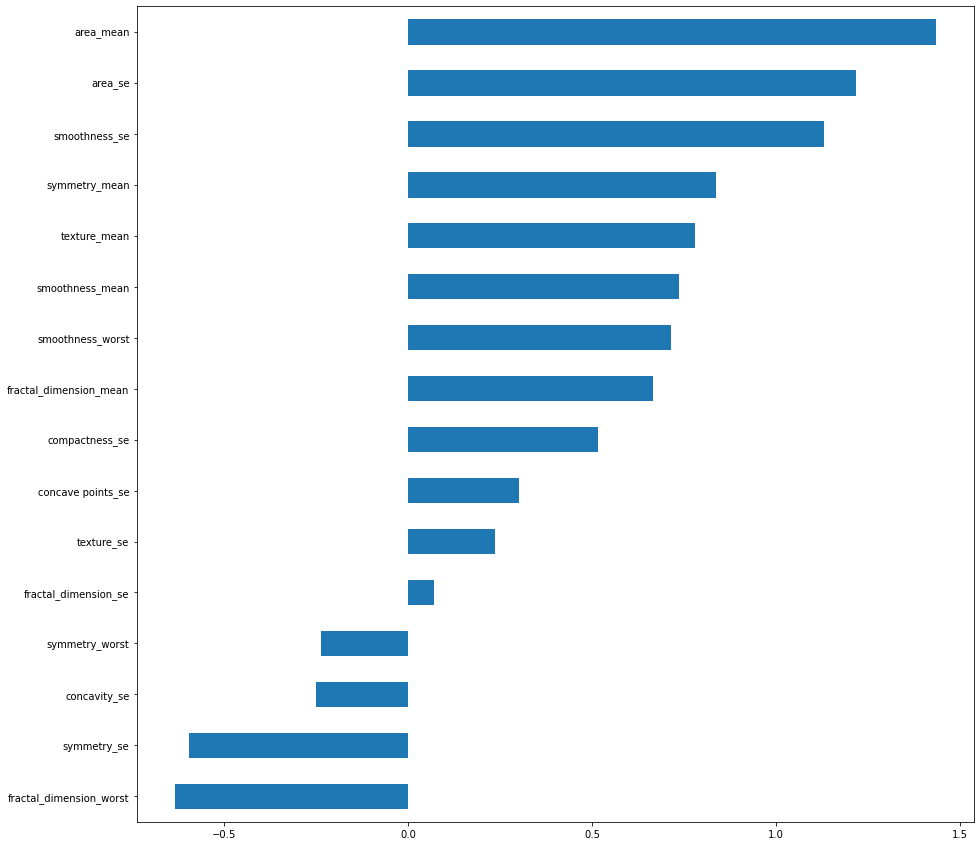

In [30]:
selected_features = grid.best_estimator_['remove_multicollinearity'].feature_names_ 
selected_features_coefficients = grid.best_estimator_['model'].coef_.flatten()

# assertion
assert grid.best_estimator_['remove_multicollinearity'].feature_names_ == retrain_pipeline['remove_multicollinearity'].feature_names_

_, ax = plt.subplots(figsize=(15, 15))
# .abs()
pd.Series(selected_features_coefficients, index=selected_features).sort_values().plot(ax=ax, kind='barh');

### Interpretation of Metric Scores on Train Set

We are also interested in choosing an optimal threshold for the model such that it gives the lowest recall, or False Negatives. We note that the default threshold when calling `predict()` from a model is $0.5$. In this section, we will explore one way to get the best tradeoff we can when choosing a high recall, while maintaining a reasonable score for precision.

In [31]:
def evaluate_train_test_set(
    estimator: Callable, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.DataFrame, np.ndarray]
) -> Dict[str, Union[float, np.ndarray]]:
    """This function takes in X and y and returns a dictionary of scores.

    Args:
        estimator (Callable): [description]
        X (Union[pd.DataFrame, np.ndarray]): [description]
        y (Union[pd.DataFrame, np.ndarray]): [description]

    Returns:
        Dict[str, Union[float, np.ndarray]]: [description]
    """

    test_results = {}

    y_pred = estimator.predict(X)
    # This is the probability array of class 1 (malignant)
    y_prob = estimator.predict_proba(X)[:, 1]

    test_brier = metrics.brier_score_loss(y, y_prob)
    test_roc = metrics.roc_auc_score(y, y_prob)

    test_results["brier"] = test_brier
    test_results["roc"] = test_roc
    test_results["y"] = np.asarray(y).flatten()
    test_results["y_pred"] = y_pred.flatten()
    test_results["y_prob"] = y_prob.flatten()

    return test_results


In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.89 
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.savefig(config.precision_recall_threshold_plot, format="png", dpi=300)
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    plt.savefig(config.roc_plot, format="png", dpi=300)
    
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

The plots below show the tradeoffs between precision and recall, recall and false positive rate. The confusion matrix on the train set tells us that there is still more false negatives than false positives. We can choose a particular threshold in order to minimize false negatives, at some expense of false positive.

In [33]:
train_results = evaluate_train_test_set(grid, X_train, y_train)

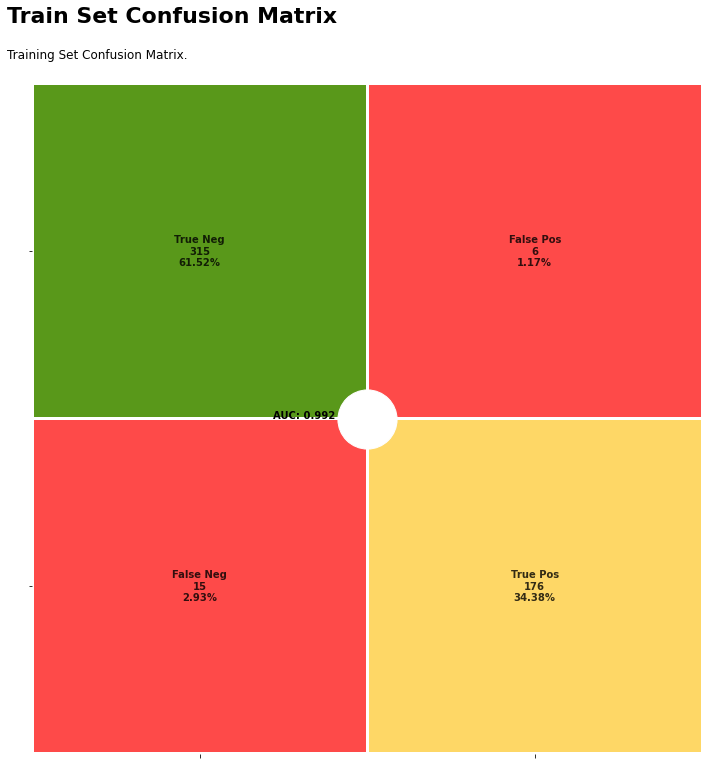

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))

# CM
cm_train = metrics.confusion_matrix(train_results['y'], train_results['y_pred'])

#### scores
auc = metrics.roc_auc_score(train_results['y'], train_results['y_prob'])

#### annotations
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
counts = ["{0:0.0f}".format(value) for value in cm_train.flatten()]
percentages = ["{0:.2%}".format(value) for value in cm_train.flatten() / np.sum(cm_train)]

#### final annotations
label = (
    np.array([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)])
).reshape(2, 2)

# heatmap
sns.heatmap(
    data=cm_train,
    vmin=0,
    vmax=330,
    cmap=["#fe4a49", "#2ab7ca", "#fed766", "#59981A"],
    linewidth=2,
    linecolor="white",
    square=True,
    ax=ax,
    annot=label,
    fmt="",
    cbar=False,
    annot_kws={"size": 10, "color": "black", "weight": "bold", "alpha": 0.8},
    alpha=1,
)



ax.scatter(1, 1, s=3500, c="white")
ax.text(
    0.72,
    1.0,
    "AUC: {}".format(round(auc, 3)),
    {"size": 10, "color": "black", "weight": "bold"},
)

## ticks and labels
ax.set_xticklabels("")
ax.set_yticklabels("")


## titles and text
fig.text(0, 1.05, "Train Set Confusion Matrix", {"size": 22, "weight": "bold"}, alpha=1)
fig.text(
    0,
    1,
    """Training Set Confusion Matrix.""",
    {"size": 12, "weight": "normal"},
    alpha=0.98,
)


fig.tight_layout(pad=2.5, w_pad=2.5, h_pad=2.5)
fig.savefig(config.final_train_confusion_matrix, format='png', dpi=300)

In [35]:
# generate the precision recall curve
precision, recall, pr_thresholds = metrics.precision_recall_curve(train_results['y'], train_results['y_prob'])
fpr, tpr, roc_thresholds = metrics.roc_curve(train_results['y'], train_results['y_prob'], pos_label=1)

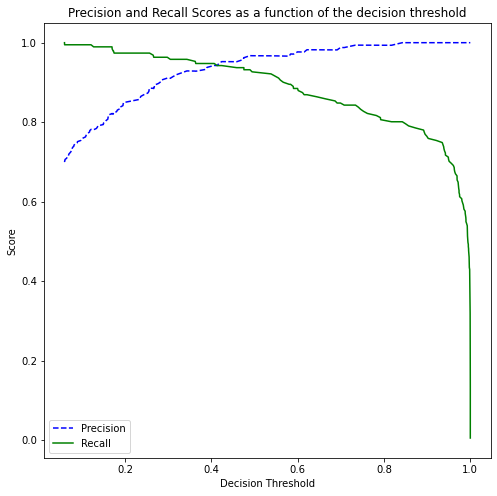

In [36]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(precision, recall, pr_thresholds)

Based on the tradeoff plot above, a good threshold can be set at $t = 0.35$, let us see how it performs with this threshold.

In [37]:
y_pred_adj = adjusted_classes(train_results["y_prob"], t=0.35)

print(
    pd.DataFrame(
        metrics.confusion_matrix(train_results["y"], y_pred_adj),
        columns=["pred_neg", "pred_pos"],
        index=["neg", "pos"],
    )
)

     pred_neg  pred_pos
neg       307        14
pos         9       182


The False Negatives reduced from 15 to 9, at the expense of increase False Positives from 6 to 14. We should take comfort that less patients are falsely classified as benign when in fact they need treatment. This is a tradeoff that we have to choose. The ROC curve below also paints a similar story, in order for you to have high recall, one must accept that there will more False Positives.

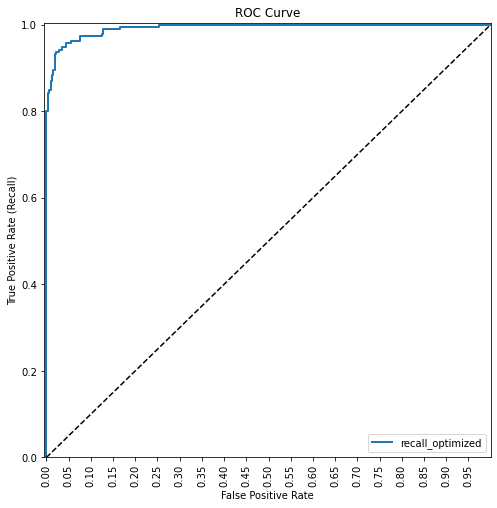

In [38]:
plot_roc_curve(fpr, tpr, 'recall_optimized')

# Evaluation on Test Set

Ultimately, we are interested in finding the estimate of the generalization error of the model, and thus it is time for us to evaluate our model's performance on the "unseen" test set $X_{\text{test}}$ to get a good gauge on how well the model generalizes to unseen data. Take note that now everything has settled, we will use the exact hyperparameters to predict on test set, with the pre-defined threshold of 0.35.

In [39]:
test_results = evaluate_train_test_set(grid, X_test, y_test)
y_test_pred_adj = adjusted_classes(test_results['y_prob'], t=0.35)

print(pd.DataFrame(metrics.confusion_matrix(test_results['y'], y_test_pred_adj),
                   columns=['pred_neg', 'pred_pos'], 
                   index=['neg', 'pos']))

     pred_neg  pred_pos
neg        33         3
pos         1        20


In [40]:
test_roc = test_results['roc']
test_brier = test_results['brier']
print(test_roc)
print(test_brier)

0.9828042328042328
0.041364243739796754


Using the same threshold we used on training set, we see that the False Negative is quite low. The overall ROC score is 0.9828, and the corresponding Brier Score is 0.04136, both seem reasonably well performing.

# Bias-Variance Tradeoff

In [41]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        grid.best_estimator_['model'], X_train.values, y_train.values, X_test.values, y_test.values, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.110
Average bias: 0.105
Average variance: 0.006


We use the `mlxtend` library to estimate the Bias-Variance Tradeoff in our Logistic Regression model. The core idea behind this function is to use bagging and repeatedly sample from our training set so as to simulate that we are actually drawing samples from the "true" population over a distribution $\mathcal{P}$. 

---

As expected, Logistic Regression being a linear model, its simplicity contributes to its high bias and low variance. 